<a href="https://colab.research.google.com/github/theroyakash/MonkeyNet/blob/master/10%20Monkey%20Species%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10 Monkey classification with custom DNN Architecture

Setting Operating System Variable 'KAGGLE_USERNAME' as theroyakash

You can download your 'KAGGLE_KEY' from kaggle's account settngs

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "theroyakash"
os.environ['KAGGLE_KEY'] = "0c952bf9d48e02510ca5a7b61823f49b"

In [2]:
!kaggle datasets download -d slothkong/10-monkey-species

 98% 537M/547M [00:07<00:00, 52.6MB/s]
100% 547M/547M [00:07<00:00, 74.1MB/s]


In [3]:
!ls

10-monkey-species.zip  sample_data


In [0]:
from zipfile import ZipFile

with ZipFile('10-monkey-species.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [5]:
!ls

10-monkey-species.zip  monkey_labels.txt  sample_data  training  validation


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
from matplotlib import pyplot as plt

In [0]:
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

In [0]:
training_datadir = '/content/training/training/'
validation_datadir = '/content/validation/validation/'
labels_path = '/content/monkey_labels.txt'

In [9]:
f = open("monkey_labels.txt", "r")
print(f.read())

Label,  Latin Name           , Common Name                   , Train Images , Validation Images
n0   , alouatta_palliata	 , mantled_howler                , 131          , 26
n1   , erythrocebus_patas	 , patas_monkey                  , 139          , 28
n2   , cacajao_calvus	     , bald_uakari                   , 137          , 27
n3   , macaca_fuscata	     , japanese_macaque              , 152          , 30
n4   , cebuella_pygmea	     , pygmy_marmoset                , 131          , 26
n5   , cebus_capucinus	     , white_headed_capuchin         , 141          , 28
n6   , mico_argentatus	     , silvery_marmoset              , 132          , 26
n7   , saimiri_sciureus	     , common_squirrel_monkey        , 142          , 28
n8   , aotus_nigriceps	     , black_headed_night_monkey     , 133          , 27
n9   , trachypithecus_johnii , nilgiri_langur                , 132          , 26















In [0]:
labels_latin = ['alouatta_palliata', 
          'erythrocebus_patas', 
          'cacajao_calvus', 
          'macaca_fuscata', 
          'cebuella_pygmea', 
          'cebus_capucinus', 
          'mico_argentatus', 
          'saimiri_sciureus', 
          'aotus_nigriceps', 
          'trachypithecus_johnii']

labels_common = ['mantled_howler', 
                 'patas_monkey', 
                 'bald_uakari', 
                 'japanese_macaque',
                 'pygmy_marmoset',
                 'white_headed_capuchin',
                 'silvery_marmoset',
                 'common_squirrel_monkey',
                 'black_headed_night_monkey',
                 'nilgiri_langur']

In [11]:
len(labels_common)

10

In [12]:
len(labels_latin)

10

In [13]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
	training_datadir,
	target_size=(200,200),
	class_mode='categorical',
    batch_size = 32
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

validation_generator = validation_datagen.flow_from_directory(
    validation_datadir,
    target_size = (200,200),
    class_mode='categorical',
    batch_size=32
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [14]:
import math
math.ceil(34.3125)

35

In [0]:
# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
#     # This is the first convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # The second convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The third convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

# model.summary()

In [0]:
# # Create a resolver
# # Distribution strategies
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [17]:
!ls

10-monkey-species.zip  monkey_labels.txt  sample_data  training  validation


In [18]:
import os
os.getcwd()

'/content'

In [19]:
!ls

10-monkey-species.zip  monkey_labels.txt  sample_data  training  validation


In [20]:
img_input = Input(shape=(200,200,3))

conv2d_1 = Conv2D(64, (3,3), activation='relu', padding='valid', name='conv2d_1')(img_input)
maxpool1 = MaxPooling2D(pool_size=(2,2))(conv2d_1)

conv2d_2 = Conv2D(128, (3,3), activation='relu', padding='valid', name='conv2d_2')(maxpool1)

conv2d_3 = Conv2D(128, (3,3), activation='relu', padding='valid', name='conv2d_3')(conv2d_2)
maxpool1 = MaxPooling2D(pool_size=(2,2))(conv2d_3)

conv2d_5 = Conv2D(128, (3,3), activation='relu', padding='valid', name='conv2d_5')(maxpool1)

branch0 = Conv2D(64, (1,1), padding='same', name='Branch_Zero_1_by_1_Conv2D')(conv2d_5)

branch1 = Conv2D(64, (1,1), activation='relu', padding='same', name='BranchOne3By3Conv2D1')(conv2d_5)
branch1 = Conv2D(64, (3,3), activation='relu', padding='same', name='BranchOne3By3Conv2D2')(branch1)
branch1 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='BranchOne3By3Conv2D3')(branch1)

concatenated_branchA = Concatenate()([branch0, branch1])
concatination_activation = Activation('relu')(concatenated_branchA)

pool0 = MaxPooling2D(pool_size=(2, 2))(concatination_activation)

branch00 = Conv2D(64, (1,1), padding='same', name='BranchZeroZero1By1Conv2D')(pool0)

branch11 = Conv2D(64, (1,1), activation='relu', padding='same', name='BranchOneOne3By3Conv2D1')(pool0)
branch11 = Conv2D(64, (3,3), activation='relu', padding='same', name='BranchOneOne3By3Conv2D2')(branch11)
branch11 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='BranchOneOne3By3Conv2D3')(branch11)

concatenated_branchB = Concatenate()([branch00, branch11])
concatenation_activation_branchB = Activation('relu')(concatenated_branchB)

flattened_before_dense = Flatten()(concatenation_activation_branchB)
dense1 = Dense(1024, activation='relu', name='firstDenseLayer')(flattened_before_dense)
dense2 = Dense(512, activation='relu', name='SecondDenseLayer')(dense1)
dense3 = Dense(128, activation='relu', name='ThirdDenseLayer')(dense2)

prediction_branch = Dense(10,activation='softmax', name='FinalSoftmaxLayer')(dense3)

model = Model(inputs=img_input, outputs=prediction_branch)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 198, 198, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 99, 99, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 97, 97, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [21]:
learning_rate, epochs = 0.001, 30

# compile our model
print("compiling model...")
model.compile(loss="categorical_crossentropy", 
              		   optimizer=Adam(lr=learning_rate, decay=learning_rate / epochs), 
			           metrics=["accuracy"])

print("Model Compiled Successfully")
print("[SUMMARY]:")
print(model.summary())

compiling model...
Model Compiled Successfully
[SUMMARY]:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 198, 198, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 99, 99, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 97, 97, 128)  73856       max_pooling2d[0][0]              
____________________________________

In [22]:
history = model.fit(train_generator, 
                    epochs=epochs, 
                    steps_per_epoch=35, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=35)

Epoch 1/30
35/35 [==============================] - 67s 2s/step - loss: 2.3170 - accuracy: 0.1102 - val_loss: 2.3025 - val_accuracy: 0.1101
Epoch 2/30
35/35 [==============================] - 68s 2s/step - loss: 2.3076 - accuracy: 0.1047 - val_loss: 2.3011 - val_accuracy: 0.1045
Epoch 3/30
35/35 [==============================] - 68s 2s/step - loss: 2.2779 - accuracy: 0.1512 - val_loss: 2.3004 - val_accuracy: 0.1026
Epoch 4/30
35/35 [==============================] - 67s 2s/step - loss: 2.2066 - accuracy: 0.1831 - val_loss: 2.1380 - val_accuracy: 0.2593
Epoch 5/30
35/35 [==============================] - 68s 2s/step - loss: 2.0938 - accuracy: 0.2149 - val_loss: 2.0660 - val_accuracy: 0.2080
Epoch 6/30
35/35 [==============================] - 69s 2s/step - loss: 2.1056 - accuracy: 0.2240 - val_loss: 2.0746 - val_accuracy: 0.2771
Epoch 7/30
35/35 [==============================] - 69s 2s/step - loss: 2.0226 - accuracy: 0.2568 - val_loss: 1.9423 - val_accuracy: 0.3144
Epoch 8/30
35/35 [==

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model , 'MonkeyNet.png' , show_shapes=True)

In [0]:
from google.colab import files
files.download('MonkeyNet.png')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

model.save('MonkeyNet.h5')
model_file = drive.CreateFile({'MonkeyNet' : 'MonkeyNet.h5'})                       
model_file.SetContentFile('MonkeyNet.h5')                       
model_file.Upload()

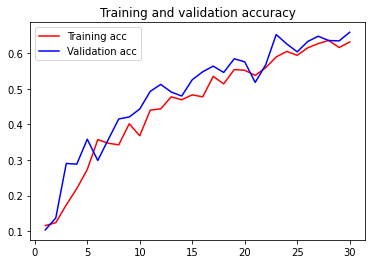

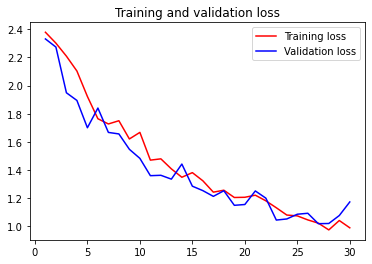

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()